# Modelli di regressione consumi Trentino

In questa sezione discuteremo la possibiltà di creare modelli per prevedere la potenza media consumata nella provincia del Trentino durante due 
diverse fascie orarie: giorno 8-19, e sera 19-24.

# Primo modello: previsione dei consumi giornalieri

Il nostro approccio si basa sull'utilizzo dei dati relativi alla giornata precedente. Vogliamo capire quali sono le features che incidono di più nella previsione della potenza media consumata: ci aspettiamo infatti che alcuni dati come l'energia consumata il giorno precedente siano molto più importanti di altri.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt


Per prima cosa carichiamo i dataframe creati durante l'EDA dividendo le fasce orarie giorno e sera definite in precedenza.

In [6]:
df_reg=pd.read_csv(r"D:\03_TURO\UNI\TRIENNALE\III_ANNO\Data_Science\Project\Data_reg\trentino_dataset_reg.csv")
df_day=df_reg[df_reg["fascia_giorno"]==1]
df_night=df_reg[df_reg["fascia_giorno"]==0]


In [7]:
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoCV, RidgeCV , ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Come prima cosa eseguiamo una pulizia manuale: ci sono delle features che sono sicuramente poco rilevanti nel nostro progetto e che si possono togliere. Tra queste troviamo ad esempio il numero di tweet e l'ID della cella. In un primo momento quindi decidiamo quali features eliminare dalla regressione. Discuteremo poi la possibilità di utilizzare per trovare potenzialmente un algoritmo di previsione migliore.

In [9]:
features_drop = [
    'cellId',
    'fascia_giorno',
    'tweet_count',
    'precip_mm',
    'NOV',
    'DEC',
    'temp_mean'
]

In quest'altro array invece ridefiniamo le features che utilizziamo nel nostro modello.

In [11]:
features_0 ={ 
 'day':'DAY',
 'UBIC_CELL':'UBIC_CELL',
 'n_linee': 'N_LINEE',
 'energy':'ENERGIA',
 'temp_min':'T_MIN',
 'temp_max':'T_MAX',
 'LU':'LUN',
 'MA':'MAR',
 'ME':'MER',
 'GI':'GIO',
 'VE':'VEN',
 'SA':'SAB',
 'DO':'DOM' ,
 'TargetReg':'Target'  
}

Data frame fascia giorno originale:

In [13]:
df_day

,cellId,day,fascia_giorno,UBIC_CELL,n_linee,energy,temp_min,temp_max,temp_mean,tweet_count,...,NOV,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg
0,155,1,1,4,1,0.072206,9.3,18.9,15.384091,0,...,1,0,0,0,0,0,1,0,0,0.128870
2,155,2,1,4,1,0.128870,12.3,15.9,13.897727,0,...,1,0,0,0,0,0,0,1,0,0.102435
4,155,3,1,4,1,0.102435,12.2,19.2,15.213636,0,...,1,0,0,0,0,0,0,0,1,0.178414
6,155,4,1,4,1,0.178414,8.6,10.9,9.402273,0,...,1,0,1,0,0,0,0,0,0,0.108142
8,155,5,1,4,1,0.108142,8.2,16.6,13.029545,0,...,1,0,0,1,0,0,0,0,0,0.121344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237912,11099,26,1,3,1,0.329076,0.1,0.8,0.436364,0,...,0,1,0,0,0,1,0,0,0,0.298320
237914,11099,27,1,3,1,0.298320,-2.9,2.0,-0.500000,0,...,0,1,0,0,0,0,1,0,0,0.317222
237916,11099,28,1,3,1,0.317222,-3.7,2.8,-0.904545,0,...,0,1,0,0,0,0,0,1,0,0.331215
237918,11099,29,1,3,1,0.331215,-0.3,2.2,0.713953,0,...,0,1,0,0,0,0,0,0,1,0.324854


Definiamo una funzione di pre-processing che divide i due dataframe originali, fascia giorno e notte, in 3 data frame (X) di training (60%), valid (20%) e test (20%). In più salviamo il vero target, ossia la potenza del giorno successivo nei data set (Y) corrispondenti di train,valid e test. Notare che il 31 dicembre essendo ultimo giorno del mese è stato eliminato perchè non abbiamo dati con cui confrontare le nostre previsioni (volendo si può fare solo una stima).

In [15]:
def pre_processing(df_day,df_night,features_drop,features):
            df_day_0=df_day.drop(columns=features_drop)
            df_day_0.rename(columns=features, inplace=True)
            df_night_0=df_night.drop(columns=features_drop)
            df_night_0.rename(columns=features, inplace=True)

            X_train_day, other = train_test_split(df_day_0, test_size=0.4, random_state=1)
            X_valid_day , X_test_day=train_test_split(other, test_size=0.5, random_state=1)
            
            X_train_night, other = train_test_split(df_night_0, test_size=0.4, random_state=1)
            X_valid_night , X_test_night=train_test_split(other, test_size=0.5, random_state=1)
            
            
            Y_train_day=X_train_day['Target']
            Y_valid_day=X_valid_day['Target']
            Y_test_day=X_test_day['Target']
            
            Y_train_night=X_train_night['Target']
            Y_valid_night=X_valid_night['Target']
            Y_test_night=X_test_night['Target']
            
            X_train_day.drop(['Target'], axis=1,inplace=True)
            X_train_night.drop(['Target'], axis=1,inplace=True)
            X_valid_day.drop(['Target'], axis=1,inplace=True)
            X_valid_night.drop(['Target'], axis=1,inplace=True)
            X_test_day.drop(['Target'], axis=1,inplace=True)
            X_test_night.drop(['Target'], axis=1,inplace=True)
            
            df_day_0.drop(['Target'], axis=1,inplace=True)
            df_night_0.drop(['Target'], axis=1,inplace=True)

          
        
            return (X_train_day, X_valid_day, X_test_day,
            Y_train_day, Y_valid_day, Y_test_day,
            X_train_night, X_valid_night, X_test_night,
            Y_train_night, Y_valid_night, Y_test_night,df_day_0,df_night_0)
           

In [16]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_0,df_night_0) = pre_processing(df_day, df_night, features_drop, features_0)

Data set aggiornato con le fetures prese in esame:

In [18]:
X_train_day

,DAY,UBIC_CELL,N_LINEE,ENERGIA,T_MIN,T_MAX,LUN,MAR,MER,GIO,VEN,SAB,DOM
162068,18,4,1,0.030685,0.5,7.4,0,0,1,0,0,0,0
11954,8,25,1,0.308270,-0.3,7.9,0,0,0,0,0,0,1
76864,3,6,1,0.046096,-2.7,8.1,0,1,0,0,0,0,0
118080,1,267,1,4.983216,11.2,15.7,0,0,0,0,1,0,0
57402,22,18,1,-0.691476,0.9,5.4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100114,18,48,1,0.303426,3.0,7.3,1,0,0,0,0,0,0
196094,27,33,1,1.089900,-8.1,-3.0,0,0,1,0,0,0,0
10384,3,48,1,0.632924,1.7,9.5,0,1,0,0,0,0,0
155416,12,4,1,0.252407,3.7,14.0,0,1,0,0,0,0,0


In [19]:
features = tuple(X_test_day.columns)

Queste sono le nostre FEATURES 

In [21]:
features

('DAY',
 'UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MIN',
 'T_MAX',
 'LUN',
 'MAR',
 'MER',
 'GIO',
 'VEN',
 'SAB',
 'DOM')

A questo punto riscaliamo i dati

In [23]:
scaler = StandardScaler()

In [24]:
scaler.fit(df_day_0)
X_train_day=scaler.transform(X_train_day)
X_valid_day=scaler.transform(X_valid_day)
X_test_day=scaler.transform(X_test_day)

X_train_night=scaler.transform(X_train_night)
X_valid_night=scaler.transform(X_valid_night)
X_test_night=scaler.transform(X_test_night)

Proviamo a plottare una heat map per vedere quali sono i dati più correlati tra loro e se possiamo fare alcune considerazioni iniziali.

<Axes: >

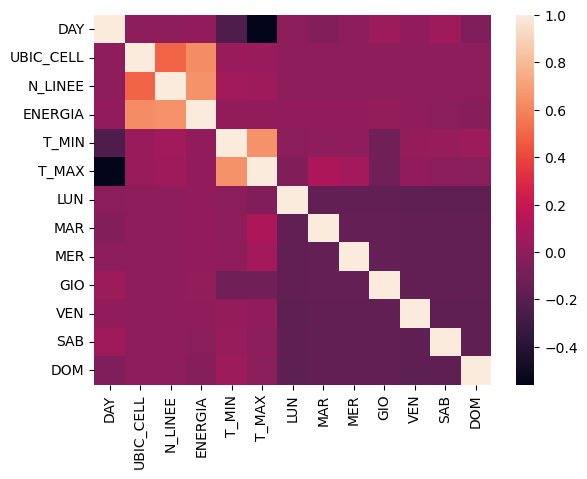

In [26]:
sns.heatmap(df_day_0.corr(method='pearson'))

Dalla heatmap osserviamo che i dati più correlati tra loro sono essenzialmente il numero di ubicazioni per cella, il numero di linea e l'energia prodotta in tale cella. Ciò è plausibilmente sensato dato che più abitazioni ci sono in una cella, più energia viene consumata e più linee saranno presenti per trasportare tale energia. Non riesco a spiegarmi sinceramente come mai il numero del giorno con la temperatura massima?? Forse perchè stiamo andando verso l'inverno e alla fine del mese farà in media più freddo.  

## Passiamo ora al predittore

Per prima cosa proviamo ad utilizzare una regressione lineare. Separiamo sempre il caso giorno e notte.


In [30]:
lin_reg_day= LinearRegression()
lin_reg_night= LinearRegression()

Definiamo una funzione per stampare gli errori

In [32]:
def print_errors(model,x_train, y_train, x_valid, y_valid):
    score_train = model.score(x_train,y_train)
    score_valid = model.score(x_valid,y_valid)

    E_train = mean_squared_error(model.predict(x_train), y_train)
    E_valid = mean_squared_error(model.predict(x_valid), y_valid)
    print(f"r^2_train {score_train} - r^2_valid {score_valid}")
    print(f"Err_train {E_train} - Err_valid {E_valid}")

Facciamo il fit sul train e score sul valid :

In [34]:
lin_reg_day.fit(X_train_day,Y_train_day)
lin_reg_night.fit(X_train_night,Y_train_night)

LinearRegression()

In [35]:
print('Modello lineare giorno:')
print_errors(lin_reg_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello lineare notte:')
print_errors(lin_reg_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello lineare giorno:
r^2_train 0.9162891877301828 - r^2_valid 0.9346591801540666
Err_train 10.896316152452236 - Err_valid 8.945388719794297
Modello lineare notte:
r^2_train 0.9408482954317523 - r^2_valid 0.9433995557332905
Err_train 5.216893509573541 - Err_valid 5.148847410946193


Osserviamo che i modelli lineari sembrano fittare abbastanza bene i dati nell'insieme di valid anche se possiamo fare certamente meglio. Notiamo poi
che il fit eseguito sui dati di notte è più preciso rispetto ai dati della fascia oraria giornaliera. Probabilmente ciò accade perchè la fascia oraria notturna è più corta, e di notte i consumi sono in media più stabili con una varianza minore rispetto alla fascia giornaliera.

Proviamo ad utilizzare il modello Ridge e a cercare il parametro ideale. Quello che fa RIDGECV è che fa lo stesso modello Ridge ma sceglie automaticamente il miglior 𝛼 usando la cross-validation. Scegliamo un array di valori per 𝛼

In [38]:
array= np.logspace(-4,0,num=20)

In [39]:
r_cv_day_0 = RidgeCV(alphas= array, cv=10)
r_cv_night_0 = RidgeCV(alphas= array, cv=10)

Usa 10-fold cross-validation per valutare quale valore di 𝛼 il modello è migliore

In [41]:
r_cv_day_0.fit(X_train_day, Y_train_day)
r_cv_night_0.fit(X_train_night, Y_train_night)
print('RidgeCV_0 giorno:')
print_errors(r_cv_day_0,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('RidgeCV_0 notte:')
print_errors(r_cv_night_0,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

RidgeCV_0 giorno:
r^2_train 0.9162904464524783 - r^2_valid 0.9346555575691577
Err_train 10.896152309386943 - Err_valid 8.9458846644466
RidgeCV_0 notte:
r^2_train 0.9408485862283427 - r^2_valid 0.9434022928042116
Err_train 5.2168678627243805 - Err_valid 5.148598424198675


Guardiamo quali sono i parametri migliori

In [43]:
r_cv_day_0.alpha_

1.0

In [44]:
r_cv_night_0.alpha_

1.0

Vediamo adesso quali sono le feature più significative per i due modelli considerati

Text(0.5, 1.0, 'Pesi r_cv_0 giorno')

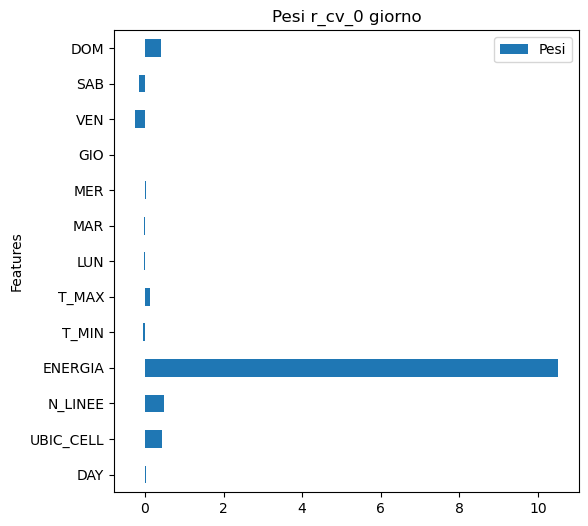

In [46]:
df_w = pd.DataFrame({'features':features, 'Pesi': r_cv_day_0.coef_})
ax = df_w.plot.barh(y='Pesi', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv_0 giorno')

Text(0.5, 1.0, 'Pesi r_cv_0 sera')

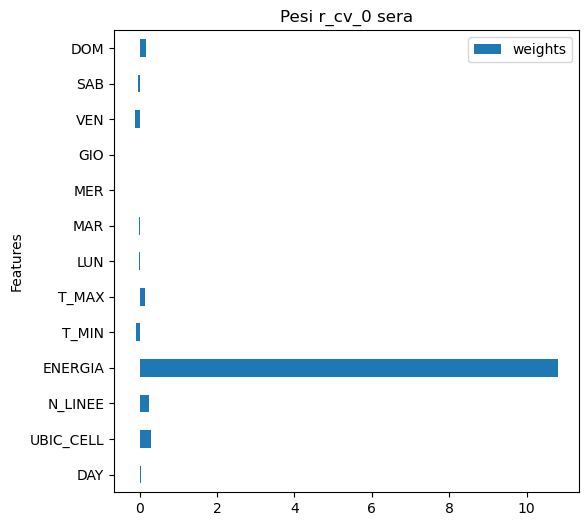

In [47]:
df_w = pd.DataFrame({'features':features, 'weights': r_cv_night_0.coef_})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi r_cv_0 sera')

Qualche osservazione. Come si poteva aspettare la feature più importante risulta proprio l'energia. Seguono il numero di linee per cella e il numero di ubicazione nella cella. Osserviamo come i giorni feriali della settimana incidano poco sul modello, mentre i giorni festivi risultano più impattanti. Anche la temperatura massima e quella minima raggiunte nell'arco della giornata non incidono molto. Sicuramente poco importante è che giorno del mese stiamo analizzando.  Possiamo quindi provare a tenere solamente le features più importanti.

Proviamo ora ad usare LassoCV: il regolarizzatore Lasso usa la norma L1 che mette in risalto le features più importanti e annulla quelle meno importanti.

In [50]:
scaler = StandardScaler()

In [51]:
array= np.logspace(-4,2,num=50)

In [52]:
r_lasso_day_1 = LassoCV(alphas=array, cv=10)
r_lasso_night_1 = LassoCV(alphas=array, cv=10)

In [53]:
r_lasso_day_1.fit(X_train_day, Y_train_day)
r_lasso_night_1.fit(X_train_night, Y_train_night)
print('LassoCV giorno:')
print_errors(r_lasso_day_1,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('LassoCV notte:')
print_errors(r_lasso_night_1,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

LassoCV giorno:
r^2_train 0.916290445578655 - r^2_valid 0.9346557292564999
Err_train 10.896152423129177 - Err_valid 8.945861159843862
LassoCV notte:
r^2_train 0.940848579668748 - r^2_valid 0.9434014347894624
Err_train 5.216868441248822 - Err_valid 5.148676476360231


Il modello è imperttibilmente peggiorato, ma i pesi del LassoCV sono molto simili a quelli del RidgeCV

In [55]:
coef = pd.Series(r_lasso_day_1.coef_, index=features)

# Ordino per importanza (valore assoluto)
coef_nonzero = coef[coef != 0].sort_values(key=np.abs, ascending=False)

print("Features selezionate dal Lasso:")
print(coef_nonzero)

print("\nNumero di features tenute:", coef_nonzero.size)
print("Numero di features eliminate:", (coef == 0).sum())

Features selezionate dal Lasso:
ENERGIA      10.502929
N_LINEE       0.482852
UBIC_CELL     0.433629
DOM           0.379732
VEN          -0.290490
SAB          -0.185409
T_MAX         0.138646
MAR          -0.059645
T_MIN        -0.058608
LUN          -0.057434
GIO          -0.033739
DAY           0.025313
MER          -0.015855
dtype: float64

Numero di features tenute: 13
Numero di features eliminate: 0


Il lasso ci da la conferma che alcune features contano molto poco rispetto ad altre: queste sono in particolare i giorni feriali della settimana, il giorno del mese, e le temperatura della giornata presa in esame. 

Proviamo ad eliminare le features inutili e a tenere quelle più importanti.

In [58]:
features_drop = [
    'cellId',
    'fascia_giorno',
    'tweet_count',
    'precip_mm',
    'NOV',
    'DEC',
    'LU',
    'MA',
    'ME',
    'GI',
    'temp_mean',
    'temp_min',
    'day',
]

In [59]:
features_1 = {
 'UBIC_CELL':'UBIC_CELL',
 'n_linee':'N_LINEE',
 'energy':'ENERGIA',
  'temp_max':'T_MAX',
 'VE':'VEN',
 'SA':'SAB',
 'DO':'DOM' ,
 'TargetReg':'Target' 
}

In [60]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_1,df_night_1) = pre_processing(df_day, df_night, features_drop, features_1)

In [61]:
features = tuple(X_test_day.columns)

In [62]:
scaler.fit(df_day_1)
X_train_day=scaler.transform(X_train_day)
X_valid_day=scaler.transform(X_valid_day)
X_test_day=scaler.transform(X_test_day)

X_train_night=scaler.transform(X_train_night)
X_valid_night=scaler.transform(X_valid_night)
X_test_night=scaler.transform(X_test_night)

Rifacciamo il RidgeCV

In [64]:
r_cv_day_1 = RidgeCV(alphas= array, cv=10)
r_cv_night_1 = RidgeCV(alphas= array, cv=10)

In [65]:
r_cv_day_1.fit(X_train_day, Y_train_day)
r_cv_night_1.fit(X_train_night, Y_train_night)
print('RidgeCV_0 giorno:')
print_errors(r_cv_day_1,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('RidgeCV_0 notte:')
print_errors(r_cv_night_1,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

RidgeCV_0 giorno:
r^2_train 0.9162614943149565 - r^2_valid 0.9346403501739784
Err_train 10.899920898356184 - Err_valid 8.947966610489141
RidgeCV_0 notte:
r^2_train 0.9408322604412154 - r^2_valid 0.9433936263661306
Err_train 5.218307717983404 - Err_valid 5.1493867955242685


Text(0.5, 1.0, 'Pesi r_cv_1 giorno')

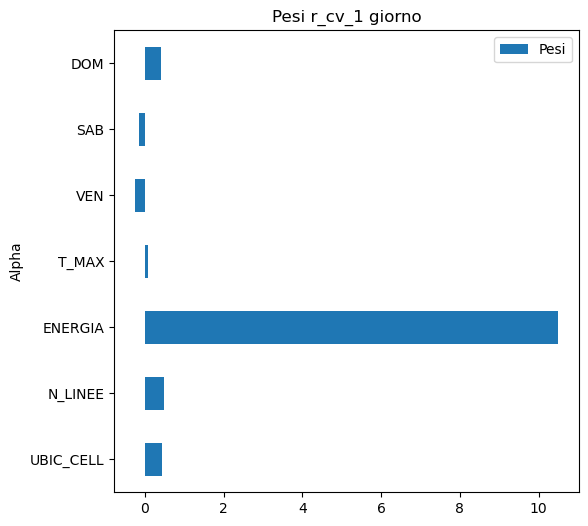

In [66]:
df_w = pd.DataFrame({'features':features, 'Pesi': r_cv_day_1.coef_})
ax = df_w.plot.barh(y='Pesi', x='features', figsize=(6, 6))
ax.set_ylabel('Alpha')
ax.set_title('Pesi r_cv_1 giorno')

Il modello è praticamente rimasto invariato, però riducendo il numero di features il modello è meno complicato e più leggero. Decidiamo di tenere questo allora.

Cerchiamo adesso il modello migliore considerando anche modelli polinomiali di grado superiore. Per farlo utilizziamo una grid search: utilizziamo l'ultimo modello con un numero minore di features per rendere l'algoritmo meno pesante computazionalmente

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
param_grid = {'model': [Ridge()],
              'model__alpha': [0.01,0.1,1.0], 
              'polynomialfeatures__degree': [1, 2, 3, 4]}  # Gradi del polinomio

# Creo una pipeline con le features polinomiali
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('model', Ridge())
])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

grid_search.fit(X_train_day, Y_train_day)
best_model_day = grid_search.best_estimator_
grid_search.fit(X_train_night, Y_train_night)
best_model_night = grid_search.best_estimator_
print('Modello migliore giorno:')
print_errors(best_model_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Modello migliore notte:')
print_errors(best_model_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

Modello migliore giorno:
r^2_train 0.9533599892985349 - r^2_valid 0.954068557705875
Err_train 6.070951746578097 - Err_valid 6.288176468408977
Modello migliore notte:
r^2_train 0.9519507642806988 - r^2_valid 0.9482861313862198
Err_train 4.237709594231183 - Err_valid 4.7043238259294515


Il modello è migliorato molto. Di seguito i parametri ottenuti dalla grid search:

In [71]:
best_model_day.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures(degree=4)),
  ('model', Ridge())],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(degree=4),
 'model': Ridge(),
 'polynomialfeatures__degree': 4,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'model__alpha': 1.0,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': None,
 'model__positive': False,
 'model__random_state': None,
 'model__solver': 'auto',
 'model__tol': 0.0001}

Uniamo i dataset train e valid e rifacciamo il train per allenare il modello su un numero di dati maggiore, confrontando infine le nostre stime di E_out e E_in usando l'insieme di test

In [73]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [74]:
best_model_day.fit(X_final_day, Y_final_day)
best_model_night.fit(X_final_night, Y_final_night)
print('Modello migliore giorno:')
print_errors(best_model_day,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(best_model_night,X_final_night,Y_final_night,X_test_night,Y_test_night)

Modello migliore giorno:
r^2_train 0.9543794626530493 - r^2_valid 0.9566868481204122
Err_train 6.015111630727146 - Err_valid 5.977474828691609
Modello migliore notte:
r^2_train 0.9517857861024717 - r^2_valid 0.9576650511979861
Err_train 4.28571886400417 - Err_valid 3.793538278851638


Osserviamo che il modello è migliorato ulteriormente. Possiamo provare a visualizzare i risultati ottenuti sino a questo punto andando a selezionare diverse celle in base alla loro energia. In questo modo mettiamo in mostra dove il nostro modello è più forte e dove può migliorare.

In [76]:
X_day=df_day_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]
X_night=df_night_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]

In [77]:
df_day_copy   = df_day.copy()
df_night_copy = df_night.copy()

df_day_copy.loc[:, 'PRED']   = best_model_day.predict(scaler.transform(X_day))
df_night_copy.loc[:, 'PRED'] = best_model_night.predict(scaler.transform(X_night))

Definiamo una funzione che ci ritorni una cella randomica tra quelle che hanno una energia tra due valori. Così possiamo confrontare il nostro modello 
casualmente.

In [79]:
def find_cell(massimo,minimo,df):

    mean = df.groupby('cellId')['energy'].mean()
    gc = mean[(massimo >mean ) & (mean > minimo)].index.tolist()

    rc = np.random.choice(gc) #scelta randomica
    return(rc)

Scegliamo quali consumi andare a visualizzare 

In [81]:
ID_alto_consumo=find_cell(500,70,df_day_copy)
ID_basso_consumo=find_cell(5,0,df_day_copy)
ID_neg_consumo=find_cell(-10,-40,df_day_copy)

Ora verifichiamo la bontà del nostro modello. Facciamo prima una panoramica generale (e poi ci soffermiamo sui giorni della settimana). Definiamo una funzione che plotti i dati

In [83]:
def plott_data(df,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
   
    fig = plt.figure(figsize=(10,8))
    gs = fig.add_gridspec(2, 2, height_ratios=[2,1])
    ax1 = fig.add_subplot(gs[0,0])   # in alto a sinistra
    ax2 = fig.add_subplot(gs[0,1])   # in alto a destra
    ax3 = fig.add_subplot(gs[1,:])   # sotto, che occupa due colonne
    
    # Primo subplot
    df_graph= df[(df["cellId"] == ID_alto_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    
    ax1.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax1.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax1.set_xlabel('Giorno')
    ax1.set_ylabel('Potenza media')
    ax1.set_title('Zona ad alto consumo')
    ax1.legend()
    
    mse1 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    
    # Secondo subplot
    df_graph= df[(df["cellId"] == ID_basso_consumo )]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax2.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax2.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax2.set_xlabel('Giorno')
    ax2.set_ylabel('Potenza media')
    ax2.set_title('Zona a basso consumo')
    ax2.legend()
    
    mse2 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    # Terzo subplot
    df_graph= df[(df["cellId"] == ID_neg_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax3.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax3.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax3.set_xlabel('Giorno')
    ax3.set_ylabel('Potenza media')
    ax3.set_title('Zona a consumo negativo')
    ax3.legend()
    
    mse3 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    return (mse1,mse2,mse3)


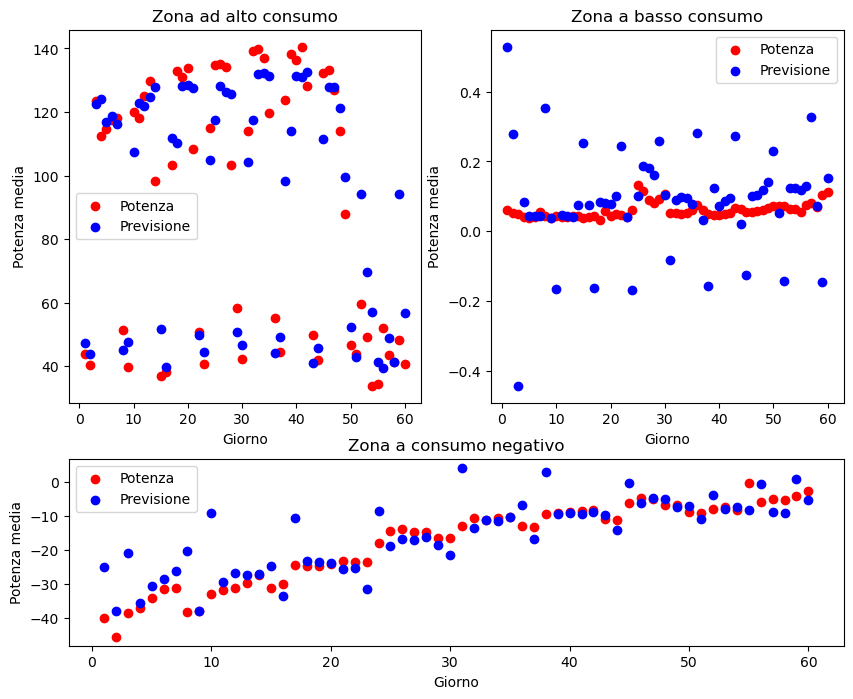

In [84]:
(mse1,mse2,mse3)=plott_data(df_day_copy,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [85]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 13.89456521072823 
 Deviazione standard 2: 0.1478467264608595 
 Deviazione standard 3: 6.7961027907544835


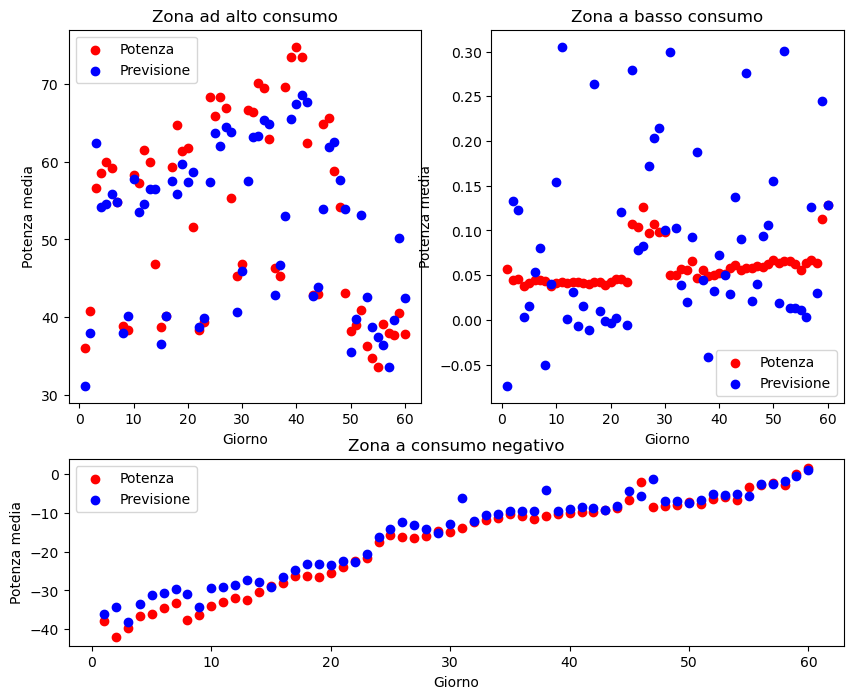

In [86]:
(mse1,mse2,mse3)=plott_data(df_night_copy,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [87]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 5.768065882212422 
 Deviazione standard 2: 0.09227401786421091 
 Deviazione standard 3: 2.970477322517703


Proviamo ora ad analizzare i dati confrontando i consumi energetici reali con quelli previsti dal modello in base al giorno della settimana, per cella ad alto consumo, a basso consumo e a consumo negativo

In [89]:
def plot_cell_energy(df_0,df_1,cell_id):
    # filtro la cella richiesta
    df_cell_0 = df_0[df_0["cellId"] == cell_id].copy()
    df_cell_1 = df_1[df_1["cellId"] == cell_id].copy()

    giorni = ["LU", "MA", "ME", "GI", "VE", "SA", "DO"]
 
    df_cell_0.loc[:, "day_of_w"] = df_cell_0[giorni].idxmax(axis=1)
  

    df_cell_0.loc[:, "day_of_w"] = pd.Categorical(df_cell_0["day_of_w"], 
                                            categories=giorni, 
                                            ordered=True)

    # trasformo in formato lungo
    df_melt_0 = df_cell_0.melt(
        id_vars=["day_of_w"], 
        value_vars=["TargetReg", "PRED"], 
        var_name="Tipo", value_name="Energia"
    )

    
    df_cell_1.loc[:, "day_of_w"] = df_cell_1[giorni].idxmax(axis=1)
  

    df_cell_1.loc[:, "day_of_w"] = pd.Categorical(df_cell_1["day_of_w"], 
                                            categories=giorni, 
                                            ordered=True)

    # trasformo in formato lungo
    df_melt_1 = df_cell_1.melt(
        id_vars=["day_of_w"], 
        value_vars=["TargetReg", "PRED"], 
        var_name="Tipo", value_name="Energia"
    )
    
    # plot a barre affiancate
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

    sns.barplot(data=df_melt_0, x="day_of_w", y="Energia", hue="Tipo", dodge=True,errorbar="sd",ax=axs[0])
    axs[0].set_title(f"Confronto energia attuale vs previsione giorno- CellId {cell_id}")
    axs[0].set_xlabel("Giorno della settimana")
    axs[0].set_ylabel("Energia")


    sns.barplot(data=df_melt_1, x="day_of_w", y="Energia", hue="Tipo", dodge=True,errorbar="sd",ax=axs[1])
    axs[1].set_title(f"Confronto energia attuale vs previsione notte - CellId {cell_id}")
    axs[1].set_xlabel("Giorno della settimana")
    axs[1].set_ylabel("Energia")


    plt.tight_layout()
    plt.show()


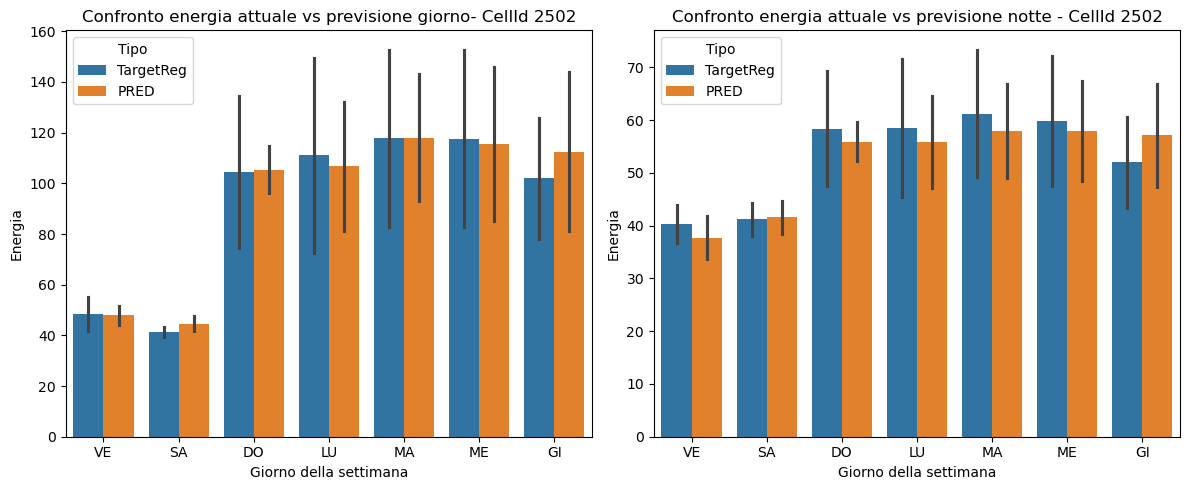

In [90]:
plot_cell_energy(df_day_copy,df_night_copy,ID_alto_consumo)

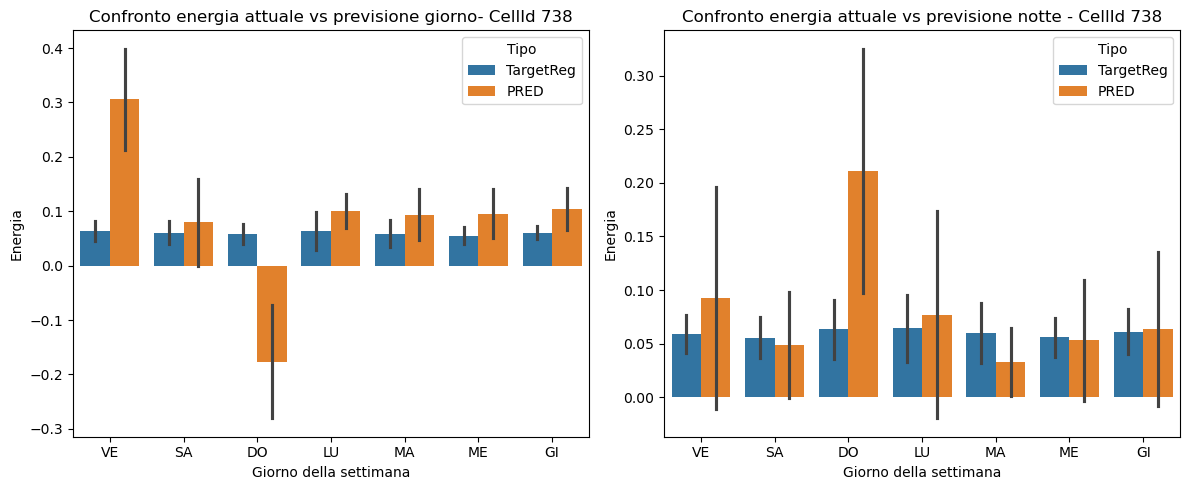

In [91]:
plot_cell_energy(df_day_copy,df_night_copy,ID_basso_consumo)

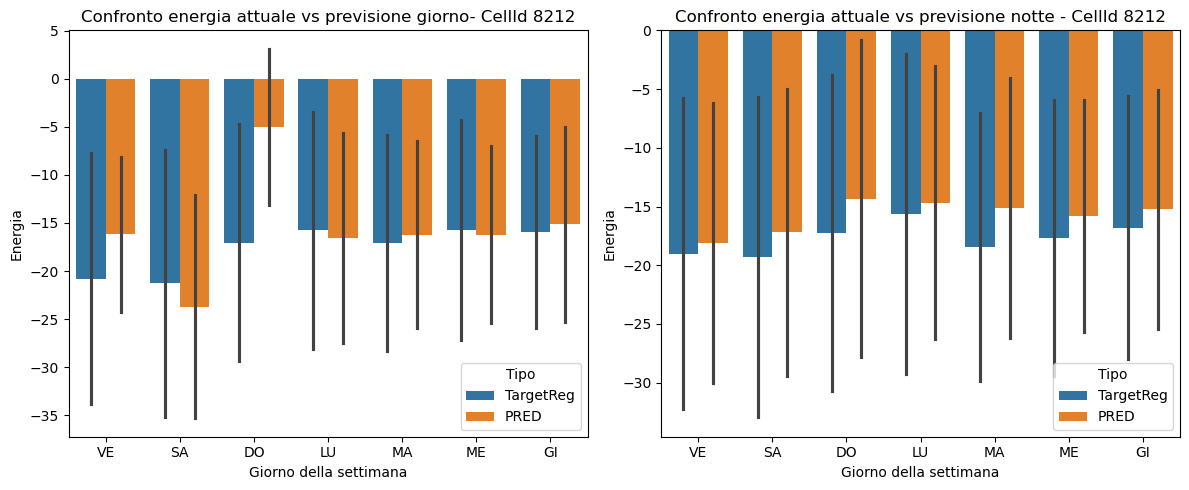

In [92]:
plot_cell_energy(df_day_copy,df_night_copy,ID_neg_consumo)

Osserviamo che il modello presenta qualche lacuna. Per quanto riguarda la cella ad alto consumo il modello tende ad avvicinarsi al target abbastanza bene. Per la cella a basso consumo osserviamo che la varianza è estremamente elevata: quando andiamo ad analizzare celle, probabilmente lontane da centri abitati, queste hanno un consumo energetico prossimo allo zero e il modello fa fatica a prevedere il dato del gionro successivo con precisione perchè non ha molte atre feature a disposizione. Anche per quanto riguarda il consumo negativo il modello non riesce a prevedere il dato bene come per la cella ad alto consumo, ma da comunque una buona stima. Pure qui la varianza è molto alta ma questo rispecchia i dati originali: si vede chiaramente nel plot dei consumi che con l'avanzare dei giorni ci avviciniamo all'inverno, con sempre meno sole, e con un trend in salita per i consumi. Per quanto riguarda le previsioni rispetto ai giorni della settimana osserviamo che....  . Si conferma il fatto già citato che il modello serale è migliore rispetto a quello diurno.

## RANDOM FOREST

Proviamo ad utilizzare una random forest

In [152]:
from sklearn.ensemble import RandomForestRegressor

In [153]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_1,df_night_1) = pre_processing(df_day, df_night, features_drop, features_1)

In [154]:
rnd_for_day=RandomForestRegressor( 
    n_estimators=500,
    criterion='squared_error',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True, 
    oob_score=True, 
    n_jobs=None, 
    random_state=None,
    verbose=2,
    warm_start=False, 
    ccp_alpha=0.0,
    max_samples=0.8, 
    monotonic_cst=None)

rnd_for_night=RandomForestRegressor( 
   n_estimators=500,
    criterion='squared_error',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True, 
    oob_score=True, 
    n_jobs=None, 
    random_state=None,
    verbose=2,
    warm_start=False, 
    ccp_alpha=0.0,
    max_samples=0.6, 
    monotonic_cst=None)


In [155]:
rnd_for_day.fit(X_train_day, Y_train_day)
rnd_for_night.fit(X_train_night, Y_train_night)
print('Random forest giorno:')
print_errors(rnd_for_day,X_train_day,Y_train_day,X_valid_day,Y_valid_day)
print('Random forest notte:')
print_errors(rnd_for_night,X_train_night,Y_train_night,X_valid_night,Y_valid_night)

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.1s


building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   14.1s


building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:   31.4s


building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.5s


building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   10.2s


building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:   22.2s


building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.4s


r^2_train 0.9647737786674879 - r^2_valid 0.9594096679457168
Err_train 4.585262454008047 - Err_valid 5.556959636368678
Random forest notte:


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.3s


r^2_train 0.9613385087449231 - r^2_valid 0.9548028578663659
Err_train 3.409756054727674 - Err_valid 4.111508156373311


L'errore è migliorato

In [157]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [158]:
X_day=df_day_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]
X_night=df_night_1[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]

In [159]:
rnd_for_day.fit(X_final_day, Y_final_day)
rnd_for_night.fit(X_final_night, Y_final_night)
print('Modello migliore giorno:')
print_errors(rnd_for_day,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(rnd_for_night,X_final_night,Y_final_night,X_test_night,Y_test_night)

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.0s


building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   17.3s


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:   40.3s


building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.2s


building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   15.8s


building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:   32.4s


building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.2s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.6s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      

r^2_train 0.9684604668607933 - r^2_valid 0.9622269401086913
Err_train 4.158517712550064 - Err_valid 5.212908894985443
Modello migliore notte:


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.2s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.5s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      

r^2_train 0.964035841380622 - r^2_valid 0.9595931894150793
Err_train 3.1968222763247764 - Err_valid 3.620762207533651


In [160]:
df_day_copy_1   = df_day.copy()
df_night_copy_1 = df_night.copy()

df_day_copy_1.loc[:, 'PRED']   = rnd_for_day.predict((X_day))
df_night_copy_1.loc[:, 'PRED'] = rnd_for_night.predict((X_night))

C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.0s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    5.6s


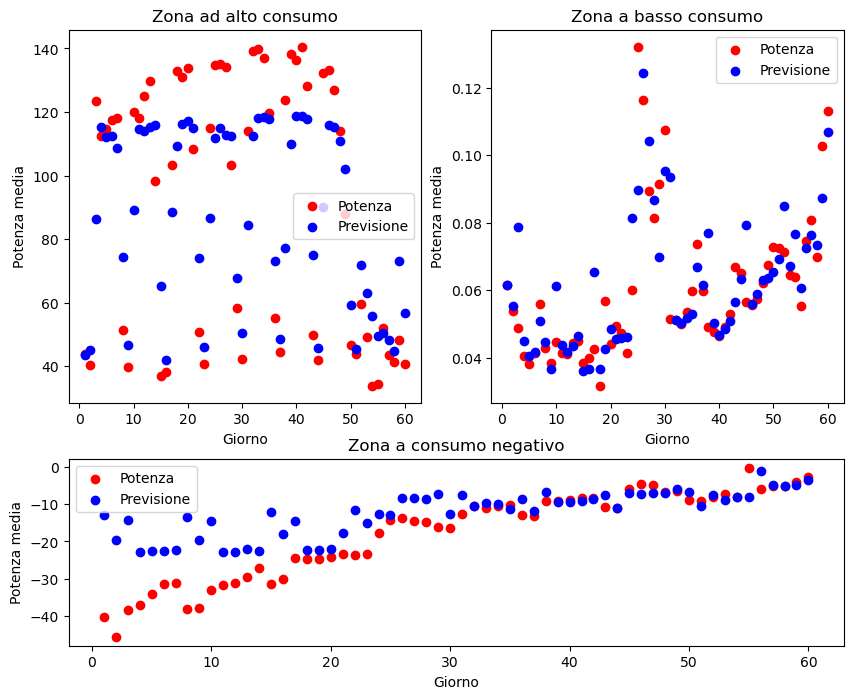

In [161]:
(mse1,mse2,mse3)=plott_data(df_day_copy_1,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [162]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 18.569828075505427 
 Deviazione standard 2: 0.012446780412516041 
 Deviazione standard 3: 9.380740510053743


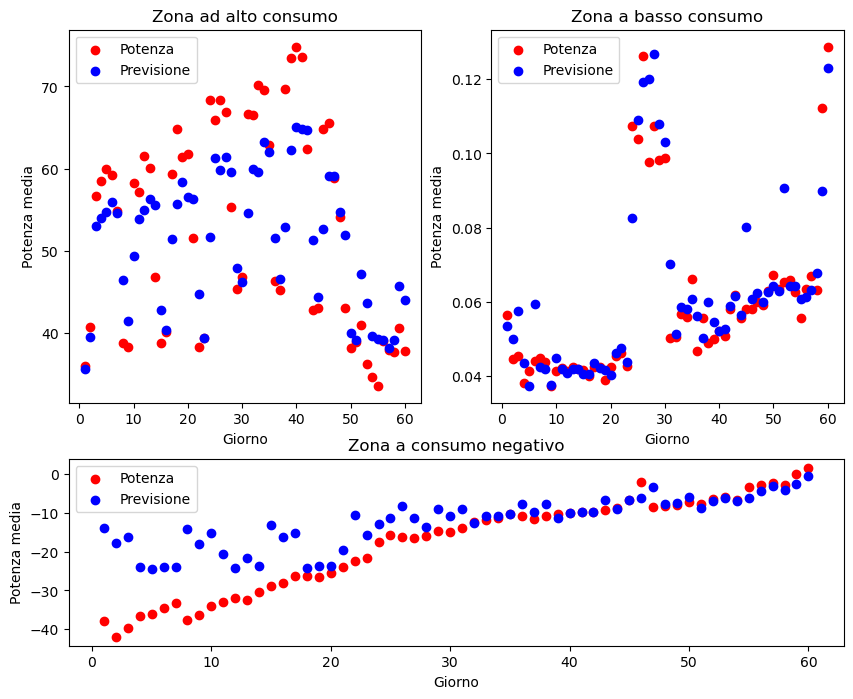

In [163]:
(mse1,mse2,mse3)=plott_data(df_night_copy_1,ID_alto_consumo,ID_basso_consumo,ID_neg_consumo)

In [164]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2, "\n Deviazione standard 3:", mse3)

Deviazione standard 1: 6.544248415551357 
 Deviazione standard 2: 0.008823305266650221 
 Deviazione standard 3: 8.978635799289318


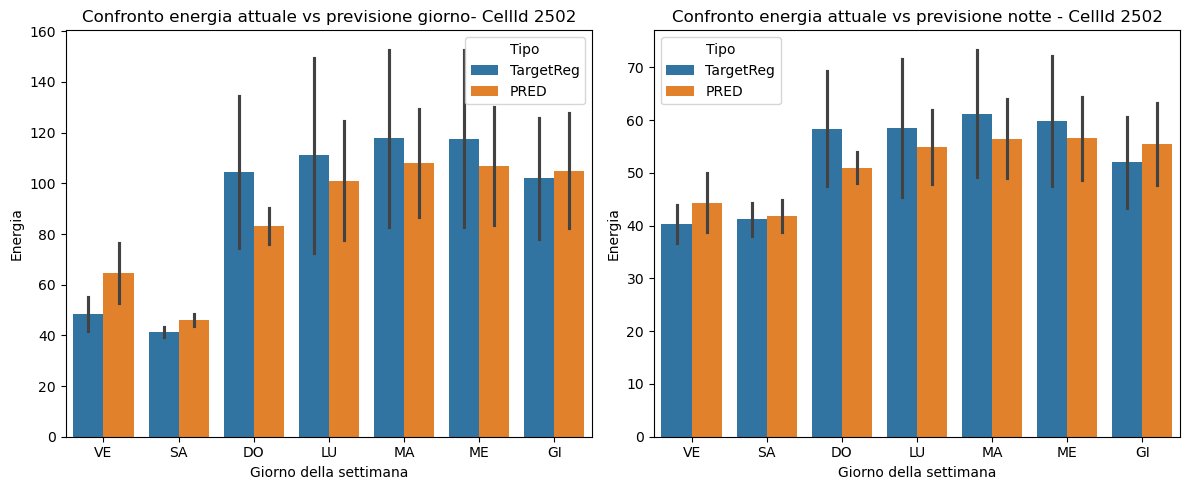

In [165]:
plot_cell_energy(df_day_copy_1,df_night_copy_1,ID_alto_consumo)

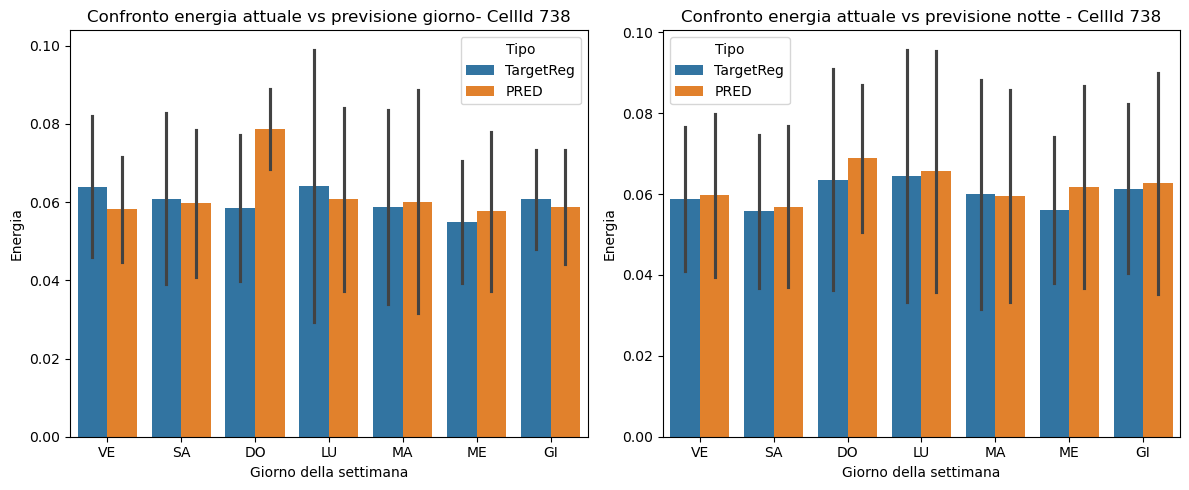

In [166]:
plot_cell_energy(df_day_copy_1,df_night_copy_1,ID_basso_consumo)

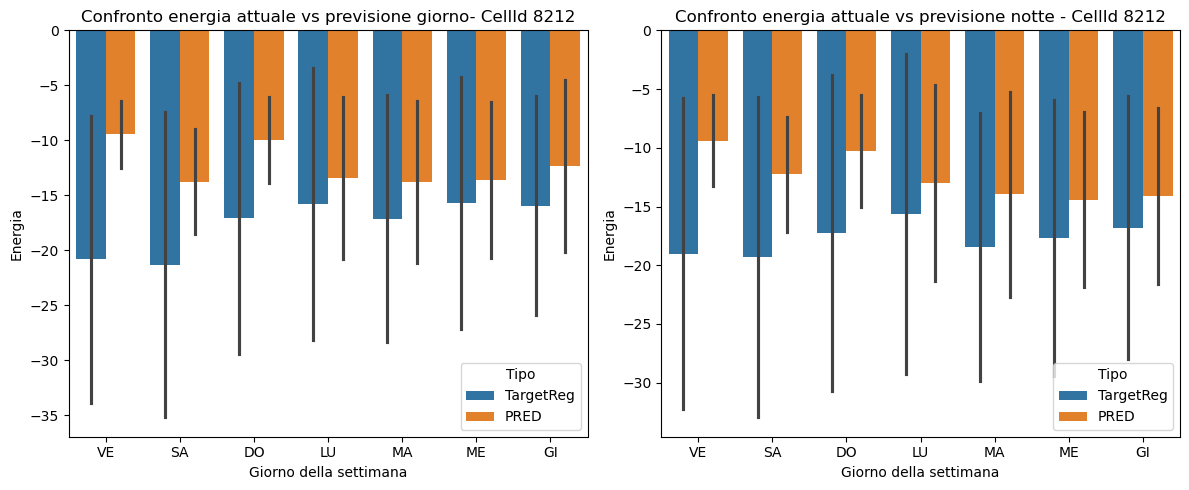

In [167]:
plot_cell_energy(df_day_copy_1,df_night_copy_1,ID_neg_consumo)

Fine prima parte

# CONSUMI A TRENTO 

Carichiamo adesso i dati riguardanti solamente il comune di Trento

In [171]:
df_reg_tn=pd.read_csv(r"D:\03_TURO\UNI\TRIENNALE\III_ANNO\Data_Science\Project\Data_reg\trentino_dataset_reg_trento.csv")

df_day_tn=df_reg_tn[df_reg_tn["fascia_giorno"]==1]
df_night_tn=df_reg_tn[df_reg_tn["fascia_giorno"]==0]

In [172]:
df_day_tn = df_day_tn.merge(
    df_day[["cellId", "day", "n_linee"]],   # solo le colonne che servono
    on=["cellId", "day"], 
    how="left"
)
df_night_tn = df_night_tn.merge(
    df_night[["cellId", "day", "n_linee"]],   # solo le colonne che servono
    on=["cellId", "day"], 
    how="left"
)

In [173]:
df_day_tn

,cellId,day,fascia_giorno,UBIC_CELL,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm,...,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg,n_linee
0,4030,1,1,10,0.343408,11.9,17.5,15.665909,0,0.0,...,0,0,0,0,0,1,0,0,0.355429,1
1,4030,1,1,10,0.343408,11.9,17.5,15.665909,0,0.0,...,0,0,0,0,0,1,0,0,0.355429,1
2,4030,2,1,10,0.355429,11.0,16.0,13.836364,0,0.6,...,0,0,0,0,0,0,1,0,0.321361,1
3,4030,2,1,10,0.355429,11.0,16.0,13.836364,0,0.6,...,0,0,0,0,0,0,1,0,0.321361,1
4,4030,3,1,10,0.321361,13.9,18.8,15.772727,0,1.2,...,0,0,0,0,0,0,0,1,0.514038,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17632,6256,28,1,6,0.115073,0.4,5.7,2.975000,0,0.0,...,1,0,0,0,0,0,1,0,0.115692,2
17633,6256,29,1,6,0.115692,3.1,4.6,3.843182,0,0.0,...,1,0,0,0,0,0,0,1,0.108612,2
17634,6256,29,1,6,0.115692,3.1,4.6,3.843182,0,0.0,...,1,0,0,0,0,0,0,1,0.108612,2
17635,6256,30,1,6,0.108612,0.5,7.2,2.909091,0,0.0,...,1,1,0,0,0,0,0,0,0.110783,2


In [174]:
col = df_day_tn.pop("n_linee")   # rimuove la colonna e la restituisce
df_day_tn.insert(4, "n_linee", col)  # la mette in posizione 5 (indice 4)
col = df_night_tn.pop("n_linee")   # rimuove la colonna e la restituisce
df_night_tn.insert(4, "n_linee", col)  # la mette in posizione 5 (indice 4)

Vediamo adesso come i modelli creati in precedenza prevedono questi dati

In [176]:
(X_train_day, X_valid_day, X_test_day,
 Y_train_day, Y_valid_day, Y_test_day,
 X_train_night, X_valid_night, X_test_night,
 Y_train_night, Y_valid_night, Y_test_night,df_day_tn_0,df_night_tn_0) = pre_processing(df_day_tn, df_night_tn, features_drop, features_1)


Vediamo se il modello imparato funziona bene per la città di Trento

Non essendoci celle a potenza negativa a Trento ci concentriamo solo su quelle ad alto consumo e a basso consumo

In [179]:
ID_alto_consumo=find_cell(300,50,df_day_tn)
ID_basso_consumo=find_cell(50,0,df_day_tn)

In [180]:
X_final_day=np.concatenate([X_train_day, X_valid_day])
X_final_night=np.concatenate([X_train_night, X_valid_night])
Y_final_day=np.concatenate([Y_train_day, Y_valid_day])
Y_final_night=np.concatenate([Y_train_night, Y_valid_night])

In [181]:
X_day=df_day_tn_0[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]
X_night=df_night_tn_0[['UBIC_CELL',
 'N_LINEE',
 'ENERGIA',
 'T_MAX',
 'VEN',
 'SAB',
 'DOM']]

In [182]:
rnd_for_day.fit(X_final_day, Y_final_day)
rnd_for_night.fit(X_final_night, Y_final_night)
print('Modello migliore giorno:')
print_errors(rnd_for_day,X_final_day,Y_final_day,X_test_day,Y_test_day)
print('Modello migliore notte:')
print_errors(rnd_for_night,X_final_night,Y_final_night,X_test_night,Y_test_night)

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.5s


building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    3.5s


building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.3s


building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    3.0s


building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.5s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.5s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      

r^2_train 0.9921812333496324 - r^2_valid 0.9881901749457638
Err_train 5.869742885312356 - Err_valid 9.202008558068215
Modello migliore notte:


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.4s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.4s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


r^2_train 0.9949227030126853 - r^2_valid 0.993625087673742
Err_train 2.253147693090403 - Err_valid 2.944477591984732


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s


In [183]:
df_day_tn_copy_0   = df_day_tn.copy()
df_night_tn_copy_0 = df_night_tn.copy()

df_day_tn_copy_0.loc[:, 'PRED']   = rnd_for_day.predict((X_day))
df_night_tn_copy_0.loc[:, 'PRED'] = rnd_for_night.predict((X_night))

C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.4s
C:\Users\03tur\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.3s


In [184]:
df_day_tn_copy_0


,cellId,day,fascia_giorno,UBIC_CELL,n_linee,energy,temp_min,temp_max,temp_mean,tweet_count,...,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg,PRED
0,4030,1,1,10,1,0.343408,11.9,17.5,15.665909,0,...,0,0,0,0,0,1,0,0,0.355429,0.342856
1,4030,1,1,10,1,0.343408,11.9,17.5,15.665909,0,...,0,0,0,0,0,1,0,0,0.355429,0.342856
2,4030,2,1,10,1,0.355429,11.0,16.0,13.836364,0,...,0,0,0,0,0,0,1,0,0.321361,0.328899
3,4030,2,1,10,1,0.355429,11.0,16.0,13.836364,0,...,0,0,0,0,0,0,1,0,0.321361,0.328899
4,4030,3,1,10,1,0.321361,13.9,18.8,15.772727,0,...,0,0,0,0,0,0,0,1,0.514038,0.452671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17632,6256,28,1,6,2,0.115073,0.4,5.7,2.975000,0,...,1,0,0,0,0,0,1,0,0.115692,0.206261
17633,6256,29,1,6,2,0.115692,3.1,4.6,3.843182,0,...,1,0,0,0,0,0,0,1,0.108612,0.317359
17634,6256,29,1,6,2,0.115692,3.1,4.6,3.843182,0,...,1,0,0,0,0,0,0,1,0.108612,0.317359
17635,6256,30,1,6,2,0.108612,0.5,7.2,2.909091,0,...,1,1,0,0,0,0,0,0,0.110783,0.150144


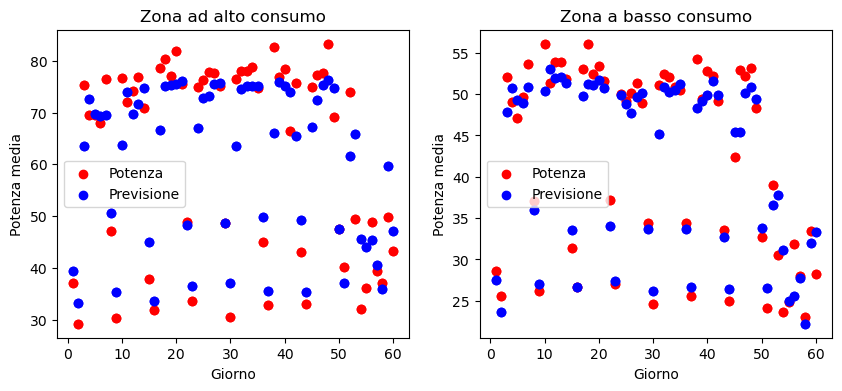

In [185]:
    df=df_day_tn_copy_0
    fig = plt.figure(figsize=(10,4))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0,0])   # in alto a sinistra
    ax2 = fig.add_subplot(gs[0,1])   # in alto a destra
    
    
    # Primo subplot
    df_graph= df[(df["cellId"] == ID_alto_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax1.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax1.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax1.set_xlabel('Giorno')
    ax1.set_ylabel('Potenza media')
    ax1.set_title('Zona ad alto consumo')
    ax1.legend()
    
    mse1 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    
    # Secondo subplot
    df_graph= df[(df["cellId"] == ID_basso_consumo )]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax2.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax2.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax2.set_xlabel('Giorno')
    ax2.set_ylabel('Potenza media')
    ax2.set_title('Zona a basso consumo')
    ax2.legend()
    
    mse2 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))

In [186]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2)

Deviazione standard 1: 6.590503878382203 
 Deviazione standard 2: 2.899583560213264


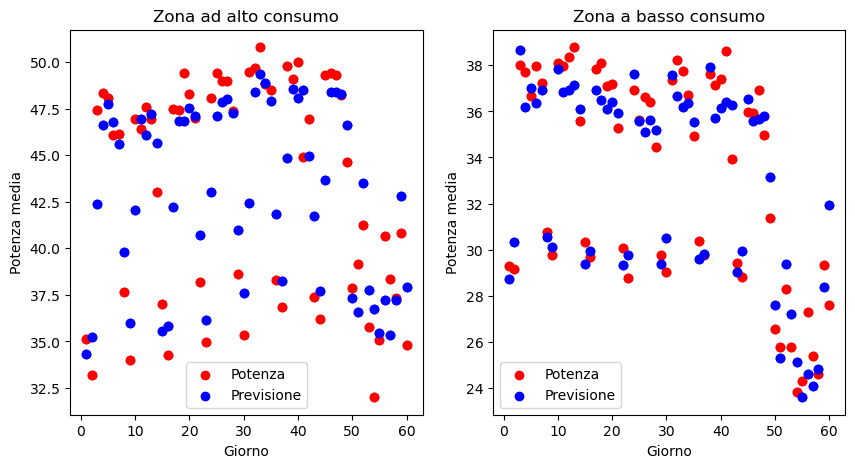

In [187]:
    df=df_night_tn_copy_0
    fig = plt.figure(figsize=(10,5))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0,0])   # in alto a sinistra
    ax2 = fig.add_subplot(gs[0,1])   # in alto a destra
    
    
    # Primo subplot
    df_graph= df[(df["cellId"] == ID_alto_consumo)]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax1.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax1.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax1.set_xlabel('Giorno')
    ax1.set_ylabel('Potenza media')
    ax1.set_title('Zona ad alto consumo')
    ax1.legend()
    
    mse1 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))
    
    
    # Secondo subplot
    df_graph= df[(df["cellId"] == ID_basso_consumo )]
    df_graph.loc[df_graph["DEC"] == 1, "day"] = df_graph["day"] + 30
    ax2.scatter(df_graph['day'], df_graph['TargetReg'], color='r', label='Potenza')
    ax2.scatter(df_graph['day'], df_graph['PRED'], color='b', label='Previsione')
    ax2.set_xlabel('Giorno')
    ax2.set_ylabel('Potenza media')
    ax2.set_title('Zona a basso consumo')
    ax2.legend()
    
    mse2 = np.sqrt(mean_squared_error(df_graph['TargetReg'], df_graph['PRED']))

In [188]:
print ("Deviazione standard 1:", mse1, "\n Deviazione standard 2:", mse2)

Deviazione standard 1: 2.623086499703138 
 Deviazione standard 2: 1.2316108360809457


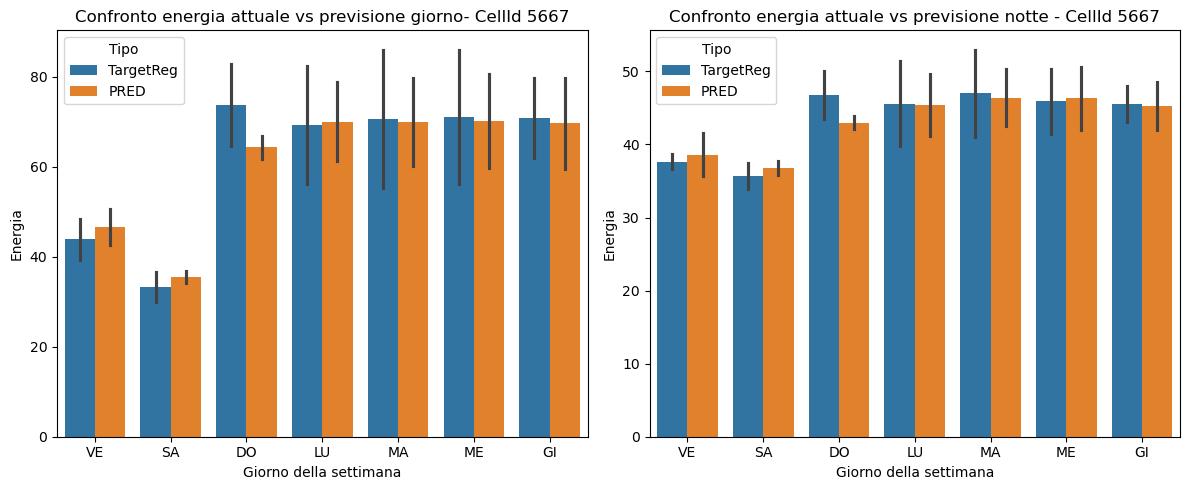

In [189]:
plot_cell_energy(df_day_tn_copy_0,df_night_tn_copy_0,ID_alto_consumo)

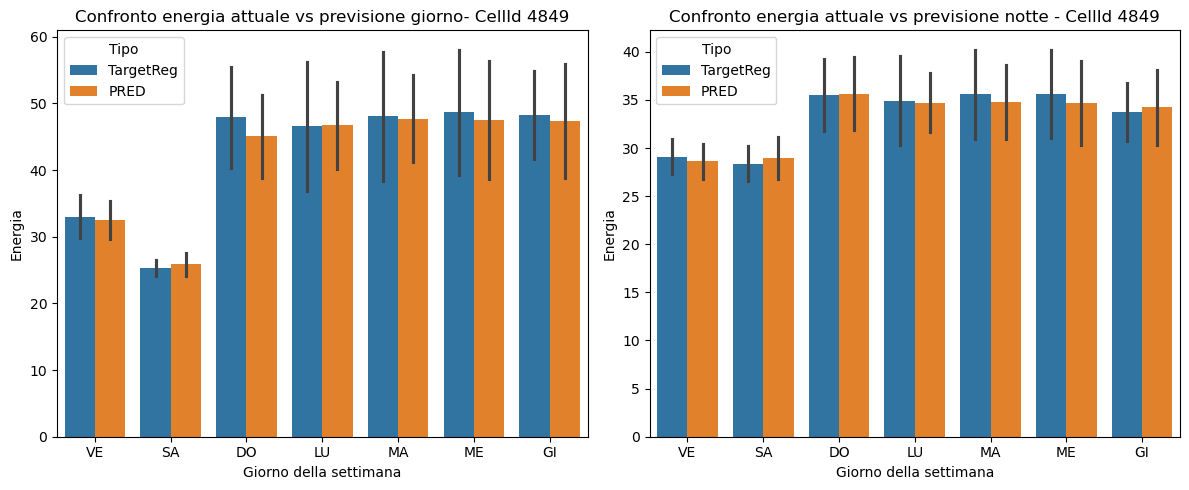

In [190]:
plot_cell_energy(df_day_tn_copy_0,df_night_tn_copy_0,ID_basso_consumo)